>>>>> STARTING TEST with K-Means, Cluster and label as classifier and  gmm  as cutting data <<<<<
Average Accuracy:  0.620803550881
Standard Deviation:  0.133955514564
Variance:  0.017944079882


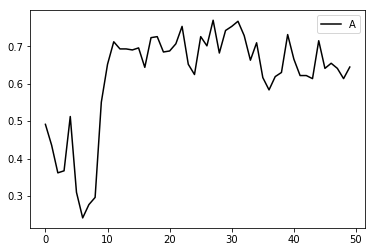

>>>>> END OF TEST <<<<<


In [1]:
import os
import pandas as pd
from testss import kmeans_svm
from testss import compose


def main():
    path = os.getcwd()+'\\data\\'
    '''
    Reading NOAA dataset:
    Eight  features  (average temperature, minimum temperature, maximum temperature, dew
    point,  sea  level  pressure,  visibility,  average wind speed, maximum  wind  speed)
    are  used  to  determine  whether  each  day  experienced  rain  or no rain.
    '''
    dataValues = pd.read_csv(path+'noaa_data.csv',sep = ",")
    dataLabels = pd.read_csv(path+'noaa_label.csv',sep = ",")
    
    #Test sets: Predicting 365 instances by step. 50 steps. Starting labeled data with 5% of 365 instances.
    ''' 
    Two classes.
    K-Means + GMM / KDE
    '''
    compose.compose(dataValues, dataLabels, 'gmm', excludingPercentage = 0.3)
    
    '''
    Test 1:
    Two classes.
    K-Means / SVM
    '''
    #kmeans_svm.kmeans_svm(dataValues, dataLabels, 'kmeans')
    

if __name__ == "__main__":
    main()